In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils
from torchvision.utils import draw_bounding_boxes as drawBox
import torchvision.transforms.functional as F
import torchvision
import torchmetrics as metrics
import torchvision.models as models
from pytorch_lightning.loggers import TensorBoardLogger
from PIL import Image
import json
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchmetrics.detection as detectionMetrics
from torchmetrics.functional.detection import intersection_over_union
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import cv2
#make sure to change these two variables below to the correct one
trainDir = '/datasets/coco/train2014'
valDir = '/datasets/coco/val2014'

# Data preps (Run this when initializing the notebook for the first time)

In [2]:
#read the keypoints file
with open('/datasets/coco/annotations/person_keypoints_train2014.json', 'r') as file:
    trainData = json.load(file)
with open('/datasets/coco/annotations/person_keypoints_val2014.json', 'r') as file:
    valData = json.load(file)

In [3]:
#convert every training and validation to pandas dataframe
trainImages = pd.DataFrame(trainData['images'])
trainAnnot = pd.DataFrame(trainData['annotations'])
valImages = pd.DataFrame(valData['images'])
valAnnot = pd.DataFrame(valData['annotations'])

In [4]:
trainImages

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,5,COCO_train2014_000000057870.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-14 16:28:13,http://farm4.staticflickr.com/3153/2970773875_...,57870
1,5,COCO_train2014_000000384029.jpg,http://images.cocodataset.org/train2014/COCO_t...,429,640,2013-11-14 16:29:45,http://farm3.staticflickr.com/2422/3577229611_...,384029
2,1,COCO_train2014_000000222016.jpg,http://images.cocodataset.org/train2014/COCO_t...,640,480,2013-11-14 16:37:59,http://farm2.staticflickr.com/1431/1118526611_...,222016
3,3,COCO_train2014_000000520950.jpg,http://images.cocodataset.org/train2014/COCO_t...,427,640,2013-11-14 16:44:40,http://farm8.staticflickr.com/7007/6413705793_...,520950
4,4,COCO_train2014_000000069675.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-14 16:46:33,http://farm8.staticflickr.com/7156/6415223357_...,69675
...,...,...,...,...,...,...,...,...
82778,1,COCO_train2014_000000444010.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-25 14:46:11,http://farm4.staticflickr.com/3697/9303670993_...,444010
82779,3,COCO_train2014_000000565004.jpg,http://images.cocodataset.org/train2014/COCO_t...,427,640,2013-11-25 19:59:30,http://farm2.staticflickr.com/1278/4677568591_...,565004
82780,3,COCO_train2014_000000516168.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-25 21:03:34,http://farm3.staticflickr.com/2379/2293730995_...,516168
82781,4,COCO_train2014_000000547503.jpg,http://images.cocodataset.org/train2014/COCO_t...,375,500,2013-11-25 21:20:21,http://farm1.staticflickr.com/178/423174638_1c...,547503


In [5]:
trainAnnot

,segmentation,num_keypoints,area,iscrowd,keypoints,image_id,bbox,category_id,id
0,"[[329.88, 211.23, 337.63, 211.93, 341.51, 210....",16,3817.67415,0,"[311, 101, 2, 315, 98, 2, 308, 97, 2, 324, 97,...",196842,"[273.14, 82.25, 72.6, 129.68]",1,183022
1,"[[41.06, 411.11, 50.61, 388.19, 39.15, 360.5, ...",17,52541.14915,0,"[145, 113, 2, 158, 96, 2, 124, 97, 2, 184, 85,...",44474,"[33.42, 11.94, 303.68, 407.76]",1,183024
2,"[[237.59, 196.4, 261.87, 197.27, 286.15, 186, ...",15,10161.01650,0,"[306, 129, 2, 309, 124, 2, 301, 125, 2, 320, 1...",382669,"[237.59, 107.09, 110.99, 241.92]",1,183026
3,"[[248.55, 319.17, 255.13, 317.12, 252.25, 267....",12,1527.58730,0,"[238, 240, 2, 239, 237, 2, 235, 239, 2, 242, 2...",188163,"[229.23, 222.96, 29.6, 97.83]",1,183028
4,"[[293.27, 191.38, 298.11, 167.71, 296.32, 160....",11,2189.62475,0,"[290, 152, 2, 293, 151, 2, 289, 149, 2, 0, 0, ...",188440,"[244.13, 130.03, 57.03, 81.46]",1,183032
...,...,...,...,...,...,...,...,...,...
185311,"{'counts': [4138, 7, 418, 12, 413, 14, 1, 2, 1...",0,23580.00000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",128732,"[9, 284, 560, 141]",1,900100128732
185312,"{'counts': [111472, 7, 365, 11, 362, 13, 360, ...",0,25439.00000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",489186,"[298, 0, 341, 127]",1,900100489186
185313,"{'counts': [13254, 1, 316, 4, 6, 1, 315, 7, 31...",0,4227.00000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",390883,"[40, 104, 394, 43]",1,900100390883
185314,"{'counts': [99015, 6, 352, 8, 350, 9, 322, 11,...",0,6478.00000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",554743,"[275, 207, 153, 148]",1,900100554743


In [ ]:
valImages

In [ ]:
valAnnot

In [150]:
#this function was declared to convert the previous cluttered 
#pandas dataframe to only take the necceessary columns
#and pre process the bounding box
def getData(imagesDf, annotDf):
    dataDict = []
    imageIdArr = annotDf['image_id'].values.tolist()
    for imgId in imageIdArr:
        tempDict = {}
        width = imagesDf.loc[imagesDf['id'] == imgId, 'width'].values
        height = imagesDf.loc[imagesDf['id'] == imgId, 'height'].values
        bboxes = annotDf.loc[annotDf['image_id'] == imgId, 'bbox'].values.tolist()
        categories = annotDf.loc[annotDf['image_id'] == imgId, 'category_id'].values.tolist()
        imageFileName = imagesDf.loc[imagesDf['id'] == imgId, 'file_name'].values[0]
        
        tempDict['imageFileName'] = imageFileName
        tempDict['width'] = width
        tempDict['height'] = height
        tempDict['bboxes'] = bboxes
        tempDict['categories'] = categories
        dataDict.append(tempDict)
    return dataDict

In [13]:
trainDataArr = getData(trainImages, trainAnnot)
valDataArr = getData(valImages, valAnnot)

In [14]:
readyTrain = pd.DataFrame(trainDataArr)

In [15]:
readyTrain

,imageFileName,width,height,bboxes,categories
0,COCO_train2014_000000196842.jpg,[500],[333],"[[273.14, 82.25, 72.6, 129.68], [205.04, 98.03...","[1, 1]"
1,COCO_train2014_000000044474.jpg,[500],[424],"[[33.42, 11.94, 303.68, 407.76]]",[1]
2,COCO_train2014_000000382669.jpg,[500],[385],"[[237.59, 107.09, 110.99, 241.92]]",[1]
3,COCO_train2014_000000188163.jpg,[427],[640],"[[229.23, 222.96, 29.6, 97.83], [158.18, 228.5...","[1, 1, 1, 1, 1, 1]"
4,COCO_train2014_000000188440.jpg,[640],[468],"[[244.13, 130.03, 57.03, 81.46], [532.15, 273....","[1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...,...,...
185311,COCO_train2014_000000128732.jpg,[640],[426],"[[63.28, 277.22, 96.05, 143.51], [454.84, 371....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
185312,COCO_train2014_000000489186.jpg,[640],[374],"[[356.23, 132.85, 37.23, 76.15], [423.08, 135....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
185313,COCO_train2014_000000390883.jpg,[500],[328],"[[287.05, 108.4, 66.62, 174.58], [253.29, 108....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
185314,COCO_train2014_000000554743.jpg,[640],[359],"[[279.34, 290.24, 14.04, 44.5], [305.84, 235.3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [16]:
#convert the recently created pandas dataframe to json to preserve the list format values
readyTrain.to_json('cleanedData.json', orient='records')

In [17]:
readyVal = pd.DataFrame(valDataArr)
readyVal.to_json('cleanedDataVal.json', orient='records')

# Start here

In [3]:
#read the recently created json files
with open('cleanedData.json', 'r') as file:
    trainingArr = json.load(file)

    
with open('cleanedDataVal.json', 'r') as file:
    valArr = json.load(file)

trainDf = pd.DataFrame(trainingArr)
valDf = pd.DataFrame(valArr)

In [142]:
trainDf

,imageFileName,width,height,bboxes,categories
0,COCO_train2014_000000196842.jpg,[500],[333],"[[273.14, 82.25, 72.6, 129.68], [205.04, 98.03...","[1, 1]"
1,COCO_train2014_000000044474.jpg,[500],[424],"[[33.42, 11.94, 303.68, 407.76]]",[1]
2,COCO_train2014_000000382669.jpg,[500],[385],"[[237.59, 107.09, 110.99, 241.92]]",[1]
3,COCO_train2014_000000188163.jpg,[427],[640],"[[229.23, 222.96, 29.6, 97.83], [158.18, 228.5...","[1, 1, 1, 1, 1, 1]"
4,COCO_train2014_000000188440.jpg,[640],[468],"[[244.13, 130.03, 57.03, 81.46], [532.15, 273....","[1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...,...,...
185311,COCO_train2014_000000128732.jpg,[640],[426],"[[63.28, 277.22, 96.05, 143.51], [454.84, 371....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
185312,COCO_train2014_000000489186.jpg,[640],[374],"[[356.23, 132.85, 37.23, 76.15], [423.08, 135....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
185313,COCO_train2014_000000390883.jpg,[500],[328],"[[287.05, 108.4, 66.62, 174.58], [253.29, 108....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
185314,COCO_train2014_000000554743.jpg,[640],[359],"[[279.34, 290.24, 14.04, 44.5], [305.84, 235.3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [147]:
trainDf['imageFileName'].nunique()

45174

In [143]:
valDf

,imageFileName,width,height,bboxes,categories
0,COCO_val2014_000000537548.jpg,[640],[480],"[[267.03, 104.32, 229.19, 320]]",[1]
1,COCO_val2014_000000117891.jpg,[640],[427],"[[206.77, 1.44, 433.23, 408.73]]",[1]
2,COCO_val2014_000000120021.jpg,[640],[480],"[[276.12, 0.29, 61.18, 118.73], [167.9, 0.62, ...","[1, 1, 1]"
3,COCO_val2014_000000403255.jpg,[640],[384],"[[355.87, 118.43, 30.84, 42.87]]",[1]
4,COCO_val2014_000000209468.jpg,[640],[480],"[[178.38, 120.54, 114.59, 354.6]]",[1]
...,...,...,...,...,...
88148,COCO_val2014_000000227049.jpg,[480],[640],"[[175.88, 521.38, 15.8, 55.66], [133.75, 522.5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
88149,COCO_val2014_000000431854.jpg,[427],[640],"[[163.23, 236.82, 235.33, 263.34], [21.45, 183...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
88150,COCO_val2014_000000382715.jpg,[425],[640],"[[129.44, 171.15, 122.25, 376.81], [296.05, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
88151,COCO_val2014_000000250282.jpg,[640],[426],"[[1.81, 187.29, 69.31, 197.46], [343.35, 182.6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [4]:
#this part is to set how much you want to use the COCO dataset
#change the SUBSET to the desired numbers
SUBSET = .02
subTrainDf = trainDf.iloc[:int(len(trainDf) * SUBSET)]
subValDf = valDf.iloc[:int(len(valDf) * SUBSET)]

In [148]:
subTrainDf['imageFileName'].nunique()

3404

In [149]:
subValDf['imageFileName'].nunique()

720

In [5]:
class customDataset(Dataset):
    def __init__(self, imageDir, dataDf, transform=None):
        self.transform = transform
        self.imageDir = imageDir
        self.dataDf = dataDf
        
    def __len__(self):
        return len(self.dataDf)
    
    def _convertXyxy(self, boxes, width, height):
        listBoxes = []
        for box in boxes:
            x, y, w, h = box
            xMin = x
            yMin = y

            xMax = x + w
            yMax = y + h

            if w == 0:
                xMax = max(xMax, x + 1)
            if h == 0:
                yMax = max(yMax, y + 1)

            xMin = max(0, x)
            yMin = max(0, y)
            xMax = min(width, xMax)
            yMax = min(height, yMax)
            listBoxes.append([xMin, yMin, xMax, yMax])
        
        return listBoxes
        
    def __getitem__(self, idx):
        fileName = self.dataDf.iloc[idx, 0]
        imgPath = os.path.join(self.imageDir, fileName)
        img = cv2.imread(imgPath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.dataDf.iloc[idx, 4]
        width = self.dataDf.iloc[idx, 1][0]
        height = self.dataDf.iloc[idx, 2][0]
        boxes = self._convertXyxy(self.dataDf.iloc[idx, 3], width, height)
                
        if self.transform:
            transformed = self.transform(image = img, bboxes=boxes, class_labels=label)
                    
        target = {}
        imgTransformed = transformed['image']
        target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
        target['labels'] = torch.tensor(transformed['class_labels'], dtype=torch.int64)
        return imgTransformed, target


In [6]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [7]:
class dataModule(pl.LightningDataModule):
    def __init__(self, trainingDir = trainDir, validationDir = valDir, trainingDf = subTrainDf, validationDf = subValDf, batchSize = 16):
        super().__init__()
        self.trainingDir = trainingDir
        self.validationDir = validationDir
        self.trainingDf = trainingDf
        self.validationDf = validationDf
        self.batchSize = batchSize
        self.classes = ['Background', 'Person']
    
    def prepare_data(self):
        pass
        
    def setup(self, stage):
        mean = [.485, .456, .406]
        std = [.229, .224, .225]
        transform = A.Compose([
            A.Resize(600,600),
            A.Normalize(mean=mean, std=std),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
        
        transformVal = A.Compose([
            A.Resize(600,600),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
        
        self.trainSet = customDataset(self.trainingDir, self.trainingDf, transform=transform)
        self.valSet = customDataset(self.validationDir, self.validationDf, transform=transformVal)
    
    def train_dataloader(self):
        return DataLoader(self.trainSet, batch_size=self.batchSize, shuffle=True, num_workers=8, drop_last=True, pin_memory=True, collate_fn=collateFn)
    
    def val_dataloader(self):
        return DataLoader(self.valSet, batch_size=self.batchSize, shuffle=False, num_workers=8, drop_last=True, pin_memory=True, collate_fn=collateFn)
    
    def predict_dataloader(self):
        return DataLoader(self.valSet, batch_size=self.batchSize, shuffle=False, num_workers=8, drop_last=True, pin_memory=True, collate_fn=collateFn)
    
def collateFn(batch):
    return tuple(zip(*batch))

In [8]:
class ResNet18_FRCNN(pl.LightningModule):
    def __init__(self, lr=0.0005, decay=0):
        super().__init__()
#         backbone = models.resnet18(weights='DEFAULT')
#         backbone = nn.Sequential(*list(backbone.children())[:-2])
        
#         ct=0
#         for child in backbone.children():
#             ct+=1
#             if ct == 8:
#                 for par in child.parameters():
#                     par.requires_grad = False
        
#         inFeat = backbone[-1][-1].conv2.out_channels
#         backbone.out_channels = inFeat
#         anchor_generator = AnchorGenerator(
#             sizes=((32, 64, 128, 256, 512),),
#             aspect_ratios=((0.5, 1.0, 2.0),)
#         )
        
#         roiPooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
#         self.model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator, box_roi_pool=roiPooler)        
        
        #THE COMMENTED ABOVE IS FOR CHANGING THE BACKBONE TO RESNET18 WHILE TRAINING THE RPN FROM THE SCRATCH
        
        backbone = models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT', weights_backbone='DEFAULT')
        in_features = backbone.roi_heads.box_predictor.cls_score.in_features
        self.model = backbone
        self.model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)
        self.mAP = detectionMetrics.mean_ap.MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
        self.met1 = detectionMetrics.IntersectionOverUnion(box_format='xyxy').to(self.device)
        self.lr = lr
        self.decay = decay
        self.mean = [.485, .456, .406]
        self.std = [.229, .224, .225]
        self.unnormalize = transforms.Normalize(mean=[-m/s for m, s in zip(self.mean, self.std)], std=[1/s for s in self.std])
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.model(images, targets)
        losses = sum(loss for loss in outputs.values())
        self.log('training_loss', losses, on_step=False, on_epoch=True, prog_bar=True, batch_size=16)
        return losses
    
    def on_validation_start(self):
        self.met1 = self.met1.to(self.device)
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.model(images)
        MAP = self.mAP.update(outputs, targets)
        
    def on_validation_end(self):
        mapDict = self.mAP.compute()
        mapAll = mapDict['map']
        map50 = mapDict['map_50']
        map75 = mapDict['map_75']
        self.logger.experiment.add_scalars('mAP', {'mAP' : mapAll}, self.global_step)
        self.logger.experiment.add_scalars('mAP_50', {'mAP_50' : map50}, self.global_step)
        self.logger.experiment.add_scalars('mAP_75', {'mAP_75' : map75}, self.global_step)
        self.print(f'mAP : {mapAll}, mAP_50 : {map50}, mAP_75 : {map75}', self.global_step)
    
    def predict_step(self, batch, batch_idx):
        img, _ = batch
        outputs = self.model(img)
        unnormImg = [self.unnormalize(image) for image in img]
        return unnormImg, outputs
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.decay, nesterov=True, momentum=0.9)

In [ ]:
#training only
dataMod1 = dataModule()
model1 = ResNet18_FRCNN(lr=0.001, decay=1e-4)
logger = TensorBoardLogger('tb_logs', name='FRCNNResNet18')
trainer1 = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=20, precision='16-mixed', default_root_dir='ckpt/last.ckpt', logger=logger)
trainer1.fit(model=model1, datamodule=dataMod1)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                  | Params
------------------------------------------------------
0 | model       | FasterRCNN            | 41.3 M
1 | mAP         | MeanAveragePrecision  | 0     
2 | met1        | IntersectionOverUnion | 0     
3 | unnormalize | Normalize             | 0     
------------------------------------------------------
41.1 M    Trainable params
222 K     Non-trainabl

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [9]:
#predict only
dataMod1 = dataModule()
model1 = ResNet18_FRCNN(lr=0.001, decay=1e-4)
logger = TensorBoardLogger('tb_logs', name='FRCNNResNet18')
trainer1 = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=20, precision='16-mixed', default_root_dir='ckpt/last.ckpt', logger=logger)
predicted = trainer1.predict(model=model1, datamodule=dataMod1, ckpt_path='/notebooks/tb_logs/FRCNNResNet18/version_8/checkpoints/epoch=38-step=9009.ckpt')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /notebooks/tb_logs/FRCNNResNet18/version_8/checkpoints/epoch=38-step=9009.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /notebooks/tb_logs/FRCNNResNet18/version_8/checkpoints/epoch=38-step=9009.ckpt


Predicting: 0it [00:00, ?it/s]

In [139]:
# print(predicted[0][0])

coba = predicted[0][1]
cobaList = [image for image in coba]
print(cobaList[0]['labels'][0])
# boxes = predicted[0][1][0]['boxes']
# labels = predicted[0][1][0]['labels']
# scores = predicted[0][1][0]['scores']

# nmses = torchvision.ops.nms(boxes=boxes, scores=scores, iou_threshold=0.5)
# print(nmses)

tensor(1)


In [10]:
def invNormalize(img):
    image = img.numpy().transpose((1,2,0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    realImage = image.transpose((2,0,1))
    realImage = torch.tensor((image * 255).astype(np.uint8)).permute(2, 0, 1)
    return realImage

In [12]:
def getNmses(preds, thresh):
    boxes = [pred['boxes'] for pred in preds]
    labels = [pred['labels'] for pred in preds]
    scores = [pred['scores'] for pred in preds]
    nmses = []
    for box, score in zip(boxes, scores):
        nmses.append(torchvision.ops.nms(boxes=box, scores=score, iou_threshold=thresh))
    return nmses

In [43]:
nmses = getNmses(predicted[0][1], 0.1)
print(len(nmses))

16


In [44]:
nmses[0]

tensor([0, 1, 2, 6])

In [41]:
def getVis(predList):
    mean = [.485, .456, .406]
    std = [.229, .224, .225]
    unnormalize = A.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
    img = predList[0][0]
    targ = predList[0][1]
    imgList = [invNormalize(image) for image in img]
    targList = [target for target in targ]
    invImg = [image for image in imgList]
    className = ['Background', 'Person']
    nmses = getNmses(targ, 0.1)
    show(drawBox(invImg[0], targList[0]['boxes'][nmses[0]], width=3))
    show(drawBox(invImg[5], targList[5]['boxes'][nmses[5]], width=3))
    show(drawBox(invImg[10], targList[10]['boxes'][nmses[10]], width=3))

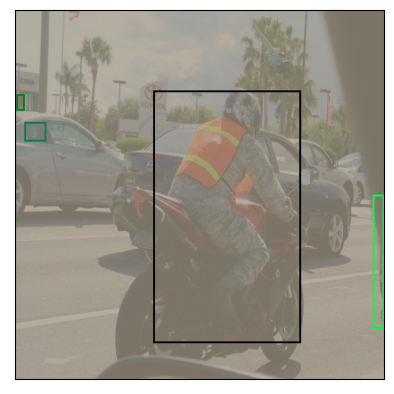

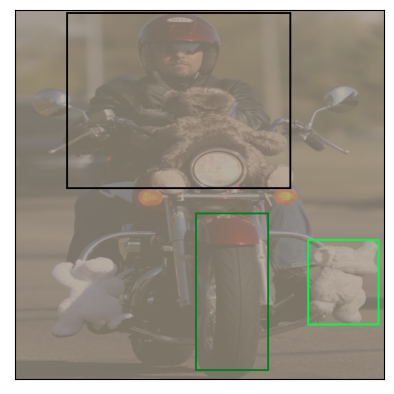

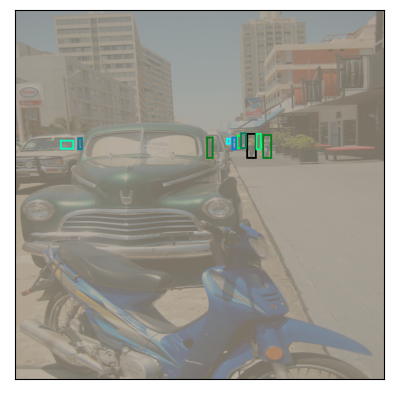

In [42]:
getVis(predicted)

In [10]:
#ONLY USE THIS TO RESUME TRAINING FROM THE PREVIOUS CKPT
#MAKE SURE THE HYPERPARAMETER WAS THE SAME
dataMod1 = dataModule()
model1 = ResNet18_FRCNN(0.01, decay=1e-4)
trainer1 = pl.Trainer(accelerator='gpu', devices=[0], max_time='00:01:00:00', precision='16-mixed', default_root_dir='ckpt/last.ckpt', logger=logger)
trainer1.fit(model=model1, datamodule=dataMod1, ckpt_path='/notebooks/tb_logs/FRCNNResNet18/version_4/checkpoints/epoch=9-step=2310.ckpt')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory tb_logs/FRCNNResNet18/version_4/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at /notebooks/tb_logs/FRCNNResNet18/version_4/checkpoints/epoch=9-step=2310.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                  | Params
------------------------------------------------------
0 | model       | FasterRCNN            | 41.3 M
1 | mAP         | MeanAveragePrecision  | 0     
2 | met1        | IntersectionOverUnion | 0     
3 | unnormalize | Normalize             | 0     
------------------------------------------------------
41.1 M    T

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mAP : 0.3099150061607361, mAP_50 : 0.5981419682502747, mAP_75 : 0.286282479763031 2541


Validation: 0it [00:00, ?it/s]

mAP : 0.3164348602294922, mAP_50 : 0.6048130989074707, mAP_75 : 0.29608482122421265 2772


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mAP : 0.3140270411968231, mAP_50 : 0.602797269821167, mAP_75 : 0.2966098487377167 3234


Validation: 0it [00:00, ?it/s]

mAP : 0.31419795751571655, mAP_50 : 0.6019573211669922, mAP_75 : 0.2959189713001251 3465


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mAP : 0.31235450506210327, mAP_50 : 0.6002672910690308, mAP_75 : 0.2930695116519928 3927


Validation: 0it [00:00, ?it/s]

mAP : 0.3121901750564575, mAP_50 : 0.6001685857772827, mAP_75 : 0.2929660677909851 4158


Validation: 0it [00:00, ?it/s]

mAP : 0.31133216619491577, mAP_50 : 0.5995820760726929, mAP_75 : 0.29336366057395935 4389


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
